In [42]:
import numpy as np
from astropy import units as u
import subprocess
import time
import tqdm
import os
import vplanet

import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import rc
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)
rc('axes', labelsize=20)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
try:
    rc('text', usetex=True)
except:
    rc('text', usetex=False)
cmodel = "b"
cdata = "r"
csample = "k"

### 1. Set up infile templates

`VPLANET` operates using `infiles` which specify all of the parameters settings used in your simulation. 

For the case of modeling the stellar evolution of an individual star, we will have two files: 
- vpl file `vpl.in` - configurations for the system (including numerical integration settings, output options, units, as well as system age) 
- body file `star.in` - represents the star, sets the stellar parameters, and specifies which stellar models are used for stellar evolution (also magnetic braking, not shown in this case) 

To run `VPLANET` in python we'll copy these [infiles](https://github.com/VirtualPlanetaryLaboratory/vplanet/tree/main/examples/StellarEvol) to strings here, 
and then create substitution strings (using `%s` for strings and `%.5f` for floats) for all parameters which we want to vary.

In [43]:
# System input file template
vpl_file = """#
sSystemName               system
iVerbose                  0           # Verbosity level
bOverwrite                1           # Allow file overwrites?
saBodyFiles               %s          # list infile names of all body files (e.g. star.in) 
bDoLog                    1           # Write a log file?
iDigits                   6           # Maximum number of digits to right of decimal
dMinValue                 1e-10       # Minimum value of eccentricity/obliquity
bDoForward                1           # Perform a forward evolution?
bVarDt                    1           # Use variable timestepping?
dEta                      0.01        # Coefficient for variable timestepping

# Input/Output Units
# Units specified in the primary input file are propagated into the bodies
sUnitMass                 solar       # Options: gram, kg, Earth, Neptune, Jupiter, solar
sUnitLength               m           # Options: cm, m, km, Earth, Jupiter, solar, AU
sUnitTime                 year        # Options: sec, day, year, Myr, Gyr
sUnitAngle                deg         # Options: deg, rad

dStopTime                 %.5f
dOutputTime               1.0e6
"""

# Star input file template
body_file = """#
sName                     %s          # body name
saModules                 stellar     # VPLanet module(s) used 
sStellarModel             baraffe     # stellar model grid
dMass                     %.5f        # stellar mass [msun]
dAge                      5e6         # age at which stellar grids are initialized [yr] (this is a fixed parameter)    
dSatXUVFrac               %.5f        # fsat = initial Lxuv / Lbol [dimensionless ratio]
dSatXUVTime               %.5f        # tsat = saturation time [yr]
dXUVBeta                  %.5f        # beta = exponential decay rate [dimensionless]


# output evolution parameters
saOutputOrder Time -Luminosity -LXUVTot Radius Temperature HZLimRecVenus HZLimRunaway HZLimMaxGreenhouse HZLimEarlyMars

# note: I'm using (-) prefix for Luminosity and LXUVTot, which will make the outputs in terms of Lsun (instead of vpl specified units)
# to see what the default (-) units are for a variable run 'vplanet -h'
"""

### 2. Define a function to write infiles with variable parameters, execute model, and read output

In [44]:
def run_stellar(input_parameters, sSystemName="star", outpath="output", quiet=False):
    """Run vplanet and collect the output."""
    
    # Time model evaluation
    t0 = time.time()
    
    # Create output directory, if it does not exist
    if not os.path.exists(outpath):
        os.mkdir(outpath)
        
    # Parse input parameters
    dMass, dSatXUVFrac, dXUVBeta, dSatXUVTime, dStopTime = input_parameters
    
    # Write the vpl.in file, substituting in variable inputs
    with open(f"{outpath}/vpl.in", "w") as file:
        saBodyFiles = sSystemName + ".in"
        print(vpl_file % (saBodyFiles, dStopTime), file=file)

    # Write star body file, substituting in variable inputs
    with open(f"{outpath}/{sSystemName}.in", "w") as file:
        print(body_file % (sSystemName, dMass, dSatXUVFrac, dSatXUVTime, dXUVBeta), file=file)
        # note: if you adjust this example, make sure these variable are substituted 
        # in the same order as your infile templates
    
    # Execute the model!
    subprocess.call(["vplanet vpl.in"], cwd=outpath, shell=True)

    # if no logfile is found, it is probably because there was something wrong with the infile formatting
    output = vplanet.get_output(outpath)
    body_output = getattr(output, sSystemName)
    
    if quiet == False:
        print("Model eval time: %.1f s"%(time.time() - t0))
    
    return body_output

### 3. Test computing this model with an initial set of parameters

Here we'll use the mass from [Delrez et. al 2022](https://arxiv.org/abs/2209.02831), and fsat, beta, tsat constraints of the Trappist-1 system (mass=0.09 Msun) [Birky et. al 2021](https://arxiv.org/abs/2105.12562)

In [45]:
mass = 0.118
fsat = 10**(-2.92)
beta = 1.18
tsat = 3e9
age  = 9e9

inparams = np.array([mass, fsat, beta, tsat, age])

evol = run_stellar(inparams, sSystemName="star", outpath="initial_infiles")

Model eval time: 11.8 s


### 4. Retrieving output arrays and handling units

In [46]:
evol.__dict__

{'_name': 'star',
 '_params': [<VPLANETQuantity [0.000e+00, 1.000e+06, 2.000e+06, ..., 8.998e+09,
                    8.999e+09, 9.000e+09] yr>,
  <VPLANETQuantity [0.028529, 0.024865, 0.021927, ..., 0.001426, 0.001426,
                    0.001426] LSUN>,
  <VPLANETQuantity [3.423450e-05, 2.983835e-05, 2.631315e-05, ...,
                    4.680708e-07, 4.679577e-07, 4.679575e-07] LSUN>,
  <VPLANETQuantity [4.162577e+08, 3.853434e+08, 3.614854e+08, ...,
                    9.932926e+07, 9.932926e+07, 9.932926e+07] m>,
  <VPLANETQuantity [3068.838994, 3082.668963, 3084.150226, ..., 2969.104446,
                    2969.104025, 2969.104025] K>,
  <VPLANETQuantity [2.060046e+10, 1.922751e+10, 1.805525e+10, ...,
                    4.614473e+09, 4.614473e+09, 4.614473e+09] m>,
  <VPLANETQuantity [2.713575e+10, 2.533017e+10, 2.378614e+10, ...,
                    6.073559e+09, 6.073559e+09, 6.073559e+09] m>,
  <VPLANETQuantity [5.208214e+10, 4.858568e+10, 4.562098e+10, ...,
              

Now that we see all of the attributes of this output object, we can get the output arrays by calling `evol.parameter`, for example:

In [47]:
evol.Radius

<VPLANETQuantity [4.162577e+08, 3.853434e+08, 3.614854e+08, ...,
                  9.932926e+07, 9.932926e+07, 9.932926e+07] m>

These output arrays make use of astropy units, and we can apply an desired unit conversions.

Here we'll just make sure everything is in solar units to make it easier to compare to our observations:

In [48]:
evol.Luminosity = evol.Luminosity.to(u.Lsun)
evol.LXUVTot = evol.LXUVTot.to(u.Lsun)
evol.Radius = evol.Radius.to(u.Rsun)
evol.Temperature = evol.Temperature.to(u.K)

In [49]:
evol.Radius

<VPLANETQuantity [0.59832931, 0.55389306, 0.51959954, ..., 0.142776  ,
                  0.142776  , 0.142776  ] solRad>

### 5. Plot evolution and compare to observational (present day) constraints

In [114]:
# Observed parameters

lbol = (1.44e-3, 0.04e-3)
lxuv_lbol = (5e-5, 2e-5)
lxuv = (lxuv_lbol[0] * lxuv_lbol[0], 
        lxuv_lbol[0] * lxuv_lbol[0] * np.sqrt(lxuv_lbol[1]**2 + lxuv_lbol[0]**2))

teff = (2950, 75)
rad = (0.1556, 0.0086)
age = (7.2e9, 2.2e9, 3.1e9)

# =========================================================================

plot_params = ["Luminosity", "LXUVTot", "Temperature", "Radius"]

def plot_evolutions(evol):
    
    fig, axs = plt.subplots(2, 2, figsize=[16,10], sharex=True, constrained_layout=True)

    # -----------------------------------

    for ii, ax in enumerate(axs.flatten()):

        # Plot evolution models
        ax.plot(evol.Time, getattr(evol, plot_params[ii]), color=cmodel)
        ax.set_ylabel(f"{plot_params[ii]} [{getattr(evol, plot_params[ii]).unit:latex}]")
        ax.set_xscale('log')

        # Plot age constraint
        ax.axvline(age[0], linestyle='--', color=cdata)
        ax.axvspan(age[0]-age[1], age[0]+age[2], color=cdata, alpha=.1)

    # -----------------------------------
    # Plot observational constraints

    axs[0][0].axhline(lbol[0], linestyle='--', color=cdata)
    axs[0][0].axhspan(lbol[0]-lbol[1], lbol[0]+lbol[1], color=cdata, alpha=.1)
    axs[0][0].set_ylabel('Total Luminosity [L$_\odot$]')

    axs[0][1].axhline(lxuv[0], linestyle='--', color=cdata)
    axs[0][1].axhspan(lxuv[0]-lxuv[1], lxuv[0]+lxuv[1], color=cdata, alpha=.1)
    axs[0][1].set_yscale('log')
    axs[0][1].set_ylabel('XUV Luminosity [L$_\odot$]')

    axs[1][0].axhline(teff[0], linestyle='--', color=cdata)
    axs[1][0].axhspan(teff[0]-teff[1], teff[0]+teff[1], color=cdata, alpha=.1)

    axs[1][1].axhline(rad[0], linestyle='--', color=cdata)
    axs[1][1].axhspan(rad[0]-rad[1], rad[0]+rad[1], color=cdata, alpha=.1)
    
    axs[1][0].set_xlabel("Time [yr]")
    axs[1][1].set_xlabel("Time [yr]")
    
    return fig, axs

/tmp/ipykernel_14927/334665498.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


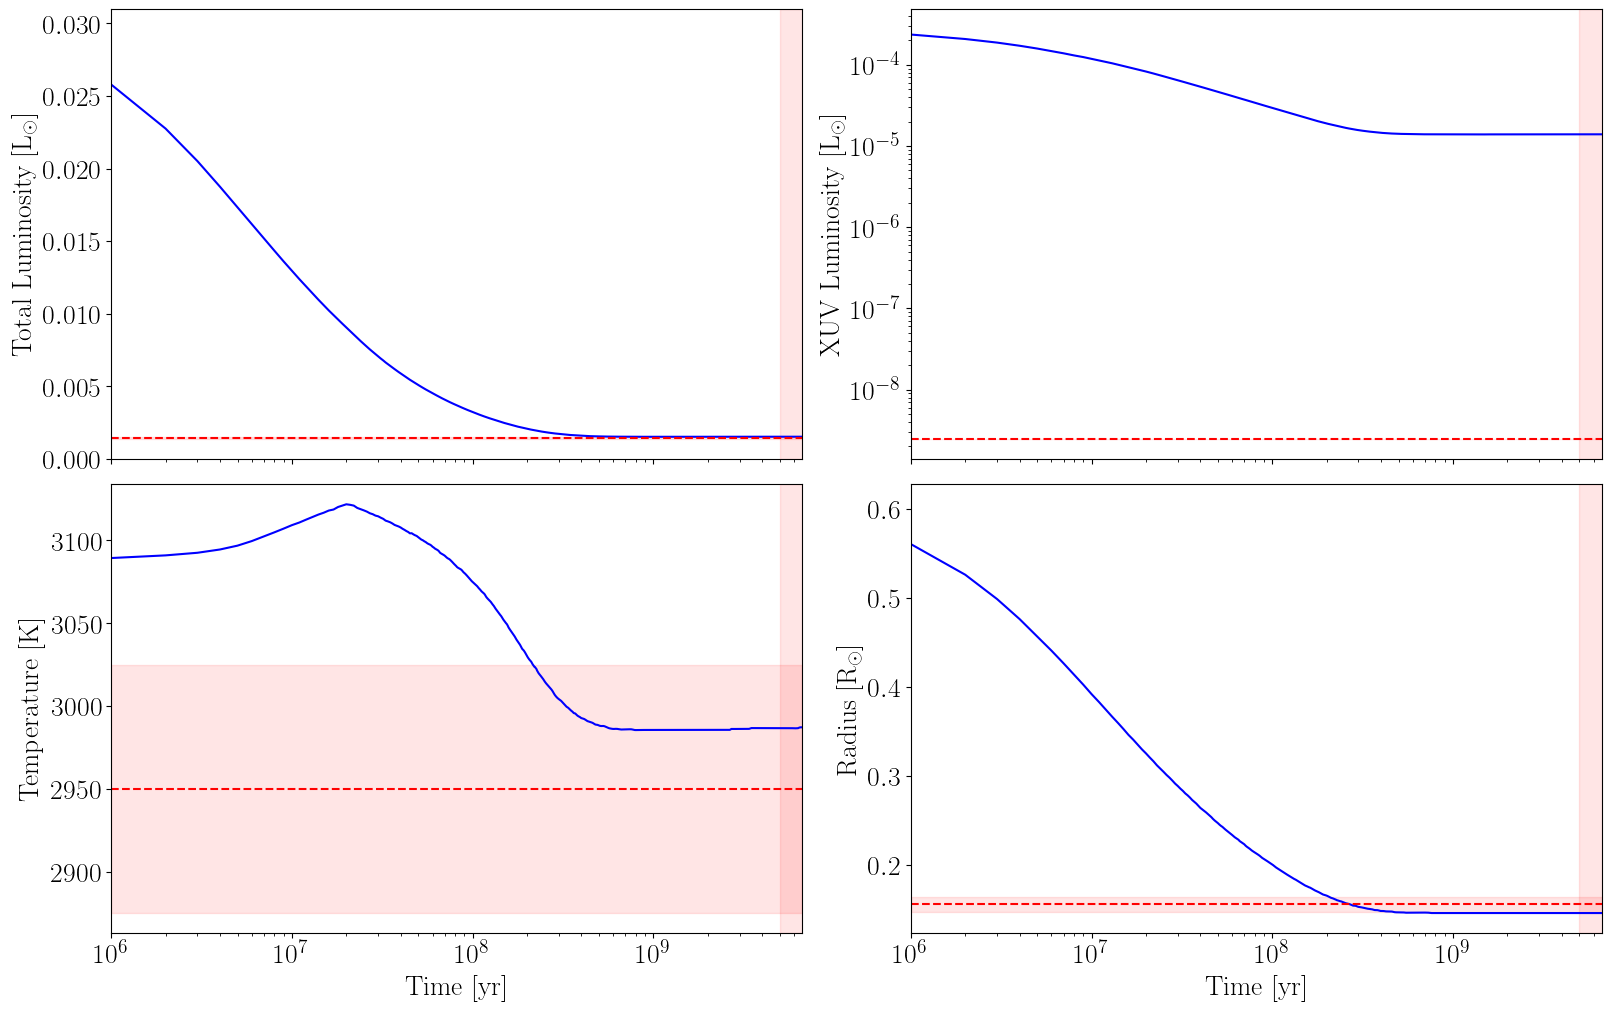

In [115]:
fig, axs = plot_evolutions(evol)
plt.xlim(evol.Time[1].value, evol.Time[-1].value)
fig.savefig("evolution_given_trappist_saturation_parameters.png")
fig.show()

### 6. How well does the model reproduce observations? Computing Model likelihood

Next let's quantify how well our simulated sample is meeting the observational constraints. To do this let's compare the final simulation values (evaluated at the simulation age) to the present-day observed values from [Delrez et. al 2022](https://arxiv.org/abs/2209.02831), using a Gaussian likelihood: 

In [52]:
def lnlike(model, data):
    # Compare final model value to observed present day value
    model_final = model[-1].value
    return (model_final - data[0])**2 / data[1]**2

In [53]:
print("Lbol likelihood:", lnlike(evol.Luminosity, lbol))
print("LXUV likelihood:", lnlike(evol.LXUVTot/evol.Luminosity, lxuv_lbol))
print("Teff likelihood:", lnlike(evol.Temperature, teff))
print("Radius likelihood:", lnlike(evol.Radius, rad))

Lbol likelihood: 0.03325763922328078
LXUV likelihood: 193.43377092506867
Teff likelihood: 0.06488244821344506
Radius likelihood: 2.223568063449305


### 7. Monte Carlo simulation

Next let's estimate a plausible range of values for fsat, beta, and tsat just using brute force Monte Carlo. We'll sample the mass and age to be gaussian around the observed constraints, and sample the other parameters over a grid:

In [65]:
nsample = 1000

mass_prior = np.random.normal(0.118, 0.002*3, nsample)
fsat_prior = 10**np.random.uniform(-5.0, -1.0, nsample)
beta_prior = np.random.uniform(0.0, 2.0, nsample)
tsat_prior = np.random.uniform(1e9, 10e9, nsample)
age_prior  = np.random.normal(7.2e9, 2.65e9, nsample)

prior_samples = np.array([mass_prior, fsat_prior, beta_prior, tsat_prior, age_prior]).T

In [66]:
evolutions  = []
likelihoods = []

for ii in tqdm.tqdm(range(nsample)):
    
    evol = run_stellar(prior_samples[ii], quiet=True)
    evol.Luminosity = evol.Luminosity.to(u.Lsun)
    evol.LXUVTot = evol.LXUVTot.to(u.Lsun)
    evol.Radius = evol.Radius.to(u.Rsun)
    evol.Temperature = evol.Temperature.to(u.K)
    evolutions.append(evol)
    
    lnlike_lbol = lnlike(evol.Luminosity, lbol)
    lnlike_lxuv = lnlike(evol.LXUVTot/evol.Luminosity, lxuv_lbol)
    
    lnlike_combined = lnlike_lbol * lnlike_lxuv
    likelihoods.append(lnlike_combined)
    
# we'll save these results to a numpy zip file, so we can look at the combined results 
np.savez("simulations.npz", evoloutions=evolutions, likelihoods=likelihoods)

100%|██████████| 1000/1000 [2:48:29<00:00, 10.11s/it]
/home/ckm/.conda/envs/vplanet/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


In [67]:
best_likelihood = np.argmin(likelihoods)
best_evolution = evolutions[best_likelihood]

print("best simulation likelihood", best_likelihood)

param_names = ["mass", "fsat", "beta", "tsat", "age"]
for ii in range(len(param_names)):
    print(param_names[ii], prior_samples[best_likelihood][ii])

best simulation likelihood 129
mass 0.11919712906343434
fsat 4.7616315574537164e-05
beta 1.8702703408639223
tsat 4912297996.510433
age 3170820126.3747334


Plot all simulations:

/tmp/ipykernel_14927/2551351192.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


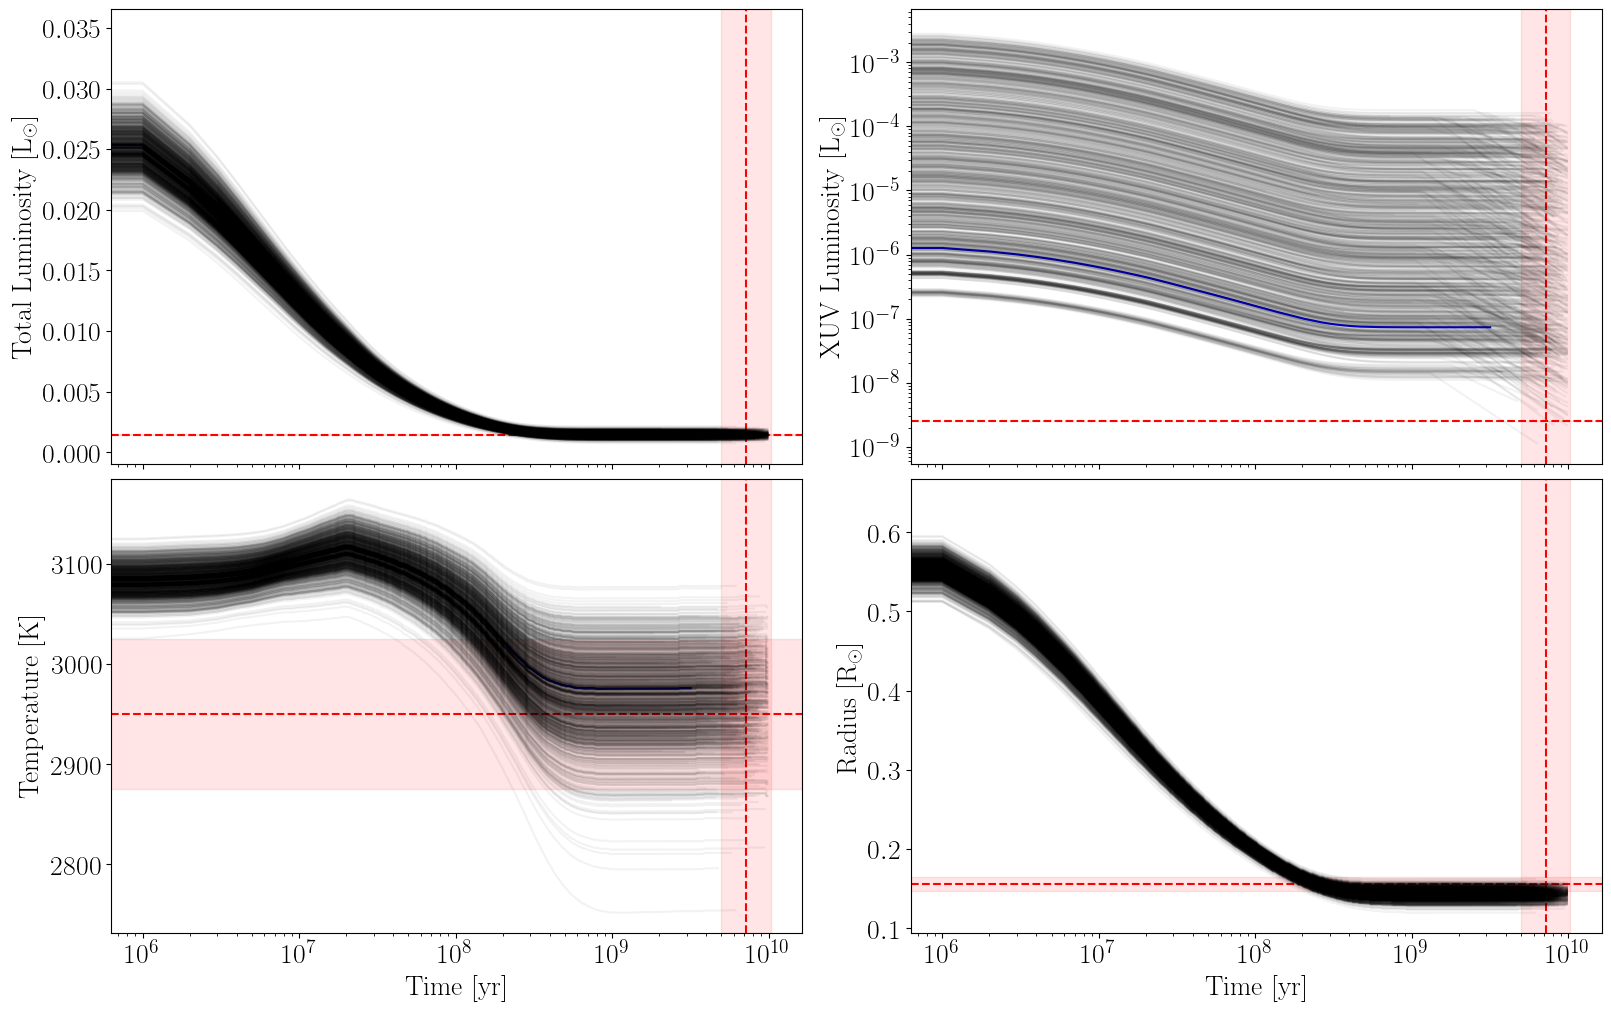

In [107]:
fig, axs = plot_evolutions(best_evolution)

# Plot evolution models of all samples
for ii, ax in enumerate(axs.flatten()):
    for evol in evolutions:
        ax.plot(evol.Time, getattr(evol, plot_params[ii]), color=csample, alpha=.05)
fig.savefig("monte_carlo_simulation.png")
fig.show()

### Habitable zone limits for this stellar mass

- **Runaway Greenhouse:** A planet's atmosphere contains greenhouse gas in an amount sufficient to block thermal radiation from leaving the planet, preventing the planet from cooling and from having liquid water on its surface.
- **Maximum Greenhouse:** Rayleigh scattering by CO2 begins to outweigh the greenhouse effect, plus a dense CO2 atmosphere is predicted to have a high albedo.

/tmp/ipykernel_14927/3703432165.py:25: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(best_evolution.Time[0].value, best_evolution.Time[-1].value)


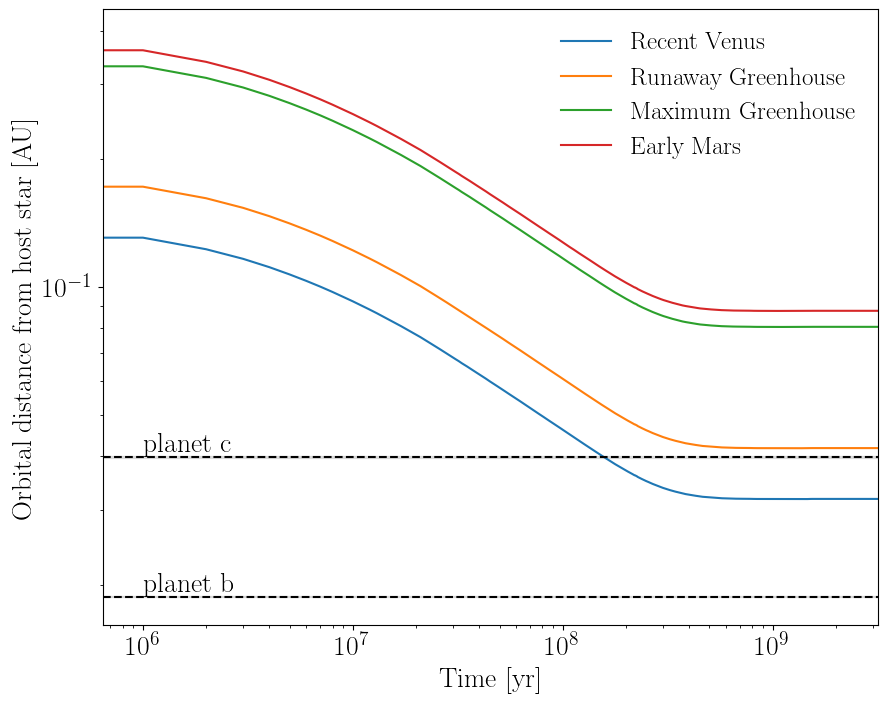

In [69]:
hz_var = ['HZLimRecVenus', 'HZLimRunaway', 'HZLimMaxGreenhouse', 'HZLimEarlyMars']
labels = ['Recent Venus', 'Runaway Greenhouse', 'Maximum Greenhouse', 'Early Mars']

planet_b = (0.01875, 0.00010)
planet_c = (0.03984, 0.00022)

plt.figure(figsize=[10,8])
for i, var in enumerate(hz_var):
    hz_evol = getattr(evol, var).to(u.AU)
    plt.plot(evol.Time, hz_evol, label=labels[i])
    
plt.axhline(planet_b[0], color="k", linestyle='--')
plt.axhspan(planet_b[0]-planet_b[1], planet_b[0]+planet_b[1], color='k', alpha=.1)
plt.text(best_evolution.Time[1].value, planet_b[0]+5*planet_b[1], "planet b", fontsize=20)

plt.axhline(planet_c[0], color="k", linestyle='--')
plt.axhspan(planet_c[0]-planet_c[1], planet_c[0]+planet_c[1], color='k', alpha=.1)
plt.text(best_evolution.Time[1].value, planet_c[0]+5*planet_c[1], "planet c", fontsize=20)

plt.legend(loc='best', fontsize=18, frameon=False)
plt.ylabel("Orbital distance from host star [AU]")
plt.xlabel("Time [yr]")
plt.xscale("log")
plt.yscale("log")
plt.xlim(best_evolution.Time[0].value, best_evolution.Time[-1].value)
# plt.savefig("habitable_zone_limits.png")
plt.show()

/tmp/ipykernel_14927/2890316321.py:35: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(best_evolution.Time[0].value, best_evolution.Time[-1].value)


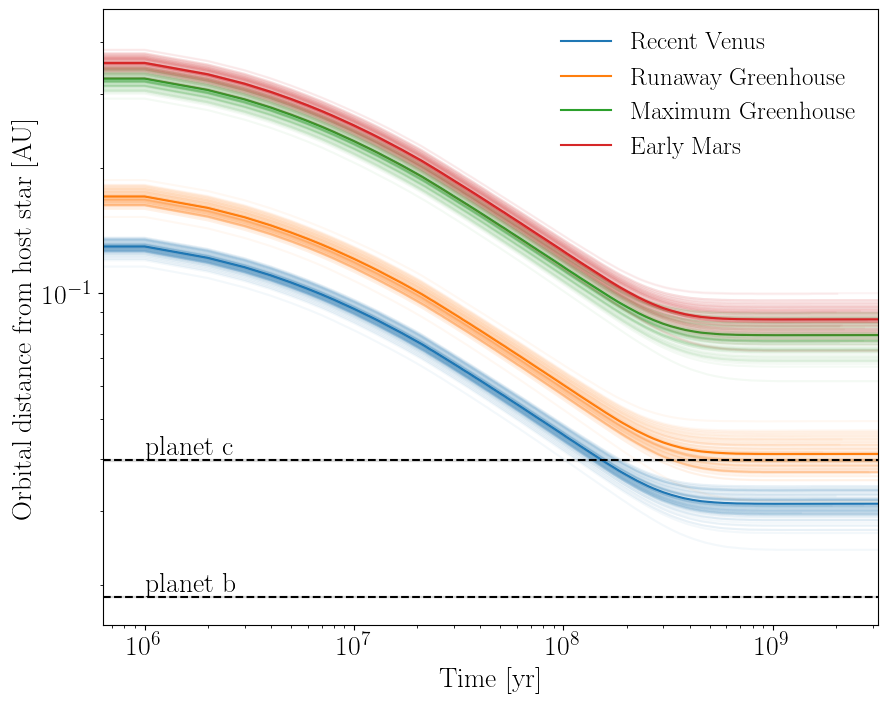

In [79]:
hz_var = ['HZLimRecVenus', 'HZLimRunaway', 'HZLimMaxGreenhouse', 'HZLimEarlyMars']
labels = ['Recent Venus', 'Runaway Greenhouse', 'Maximum Greenhouse', 'Early Mars']

planet_b = (0.01875, 0.00010)
planet_c = (0.03984, 0.00022)

for idx, var in enumerate(hz_var):
    for i, evol in enumerate(evolutions):
        hz_evol = getattr(evol, var).to(u.AU)

plt.figure(figsize=[10,8])
for idx, var in enumerate(hz_var):
    for i, evol in enumerate(evolutions):
        hz_evol = getattr(evol, var).to(u.AU)
        if i == 0:
            plt.plot(evol.Time, hz_evol, label=labels[idx], color=f'C{idx}')
        elif np.random.rand() < 0.1:
            ax = plt.gca()  # get current axis
            ax.plot(evol.Time, hz_evol, alpha=.05, color=f'C{idx}')
    
plt.axhline(planet_b[0], color="k", linestyle='--')
plt.axhspan(planet_b[0]-planet_b[1], planet_b[0]+planet_b[1], color='k', alpha=.1)
plt.text(best_evolution.Time[1].value, planet_b[0]+5*planet_b[1], "planet b", fontsize=20)

plt.axhline(planet_c[0], color="k", linestyle='--')
plt.axhspan(planet_c[0]-planet_c[1], planet_c[0]+planet_c[1], color='k', alpha=.1)
plt.text(best_evolution.Time[1].value, planet_c[0]+5*planet_c[1], "planet c", fontsize=20)

plt.legend(loc='best', fontsize=18, frameon=False)
# plt.title("Habitable zone limits", fontsize=25)
plt.ylabel("Orbital distance from host star [AU]")
plt.xlabel("Time [yr]")
plt.xscale("log")
plt.yscale("log")
plt.xlim(best_evolution.Time[0].value, best_evolution.Time[-1].value)
plt.savefig("habitable_zone_limits_1000sample.png")
plt.show()